In [156]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time
from astropy.wcs.wcsapi import SlicedLowLevelWCS
from astropy.visualization import ImageNormalize, AsinhStretch
from sunpy.coordinates import Helioprojective, HeliographicStonyhurst
from sunraster import SpectrogramCube
from sunraster.instr.spice import read_spice_l2_fits
import gwcs
import gwcs.coordinate_frames as cf
import matplotlib.pyplot as plt
from astropy.modeling import models, Model, Parameter, InputParameterError, custom_model

In [2]:
with fits.open('~/Downloads/solo_L2_spice-n-ras_20210914T025031_V09_67109159-000.fits') as hdul:
    hdul.info()
    data = hdul[4].data.copy()
    header = hdul[4].header.copy()
    wcsdvarr_x = hdul[8].data.copy()
    wcsdvarr_y = hdul[9].data.copy()


Filename: /home/yjzhu/Downloads/solo_L2_spice-n-ras_20210914T025031_V09_67109159-000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  O III 703 + Mg IX 706 (Merged)    1 PrimaryHDU     408   (224, 1024, 82, 1)   float32   
  1  O II 718 - Peak    1 ImageHDU       403   (224, 1024, 50, 1)   float32   
  2  Ne VIII 770 - Peak    1 ImageHDU       403   (224, 1024, 50, 1)   float32   
  3  S V 786 / O IV 787 - Peak    1 ImageHDU       403   (224, 1024, 50, 1)   float32   
  4  C III 977 - Peak    1 ImageHDU       403   (224, 1024, 36, 1)   float32   
  5  Ly Beta 1025 (Merged)    1 ImageHDU       408   (224, 1024, 31, 1)   float32   
  6  O VI 1032 - Peak    1 ImageHDU       403   (224, 1024, 34, 1)   float32   
  7  VARIABLE_KEYWORDS    1 BinTableHDU    398   1R x 28C   [224D, 224I, 224I, 224I, 224I, 224I, 224E, 224E, 224E, 224E, 7I, 7I, 7I, 7I, 7J, 7J, 7J, 7J, 5152A, 224D, 224D, 82D, 50D, 50D, 50D, 36D, 31D, 34D]   
  8  WCSDVARR      1 ImageHDU        28   (224,) 

In [3]:
spice_cubes = read_spice_l2_fits('~/Downloads/solo_L2_spice-n-ras_20210914T025031_V09_67109159-000.fits')
spice_wcs = spice_cubes['C III 977 - Peak'].wcs

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-OBS to 59471.118421 from DATE-OBS.
Set MJD-BEG to 59471.118421 from DATE-BEG.
Set MJD-AVG to 59471.144347 from DATE-AVG.
Set MJD-END to 59471.170269 from DATE-END'. [astropy.wcs.wcs]


In [68]:
class AffineTransformation3D(Model):

    n_inputs = 3
    n_outputs = 3

    standard_broadcasting = False

    _separable = False

    matrix = Parameter(default=[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0],
                                [0.0, 0.0, 0.1]])

    def _matrix_validator(self, value):
        """Validates that the input matrix is a 4x4 2D array."""
        if np.shape(value) != (3, 3):
            raise InputParameterError(
                "Expected transformation matrix to be a 3x3 array"
            )

    matrix._validator = _matrix_validator

    def __init__(self, matrix=matrix, **kwargs):
        super().__init__(matrix=matrix, **kwargs)
        self.inputs = ("x", "y", "time")
        self.outputs = ("x", "y", "time")

    @property
    def inverse(self):
        """
        Inverse transformation.

        Raises `~astropy.modeling.InputParameterError` if the transformation cannot be inverted.
        """
        det = np.linalg.det(self.matrix.value)

        if det == 0:
            raise InputParameterError(
                f"Transformation matrix is singular; {self.__class__.__name__} model"
                " does not have an inverse"
            )

        matrix = np.linalg.inv(self.matrix.value)
        if self.matrix.unit is not None:
            matrix = matrix * self.matrix.unit
        # If matrix has unit then translation has unit, so no need to assign it.
        return self.__class__(matrix=matrix,)


    @classmethod
    def evaluate(cls, x, y, time, matrix):
        """
        Apply the transformation to a set of 2D Cartesian coordinates given as
        two lists--one for the x coordinates and one for a y coordinates--or a
        single coordinate pair.

        Parameters
        ----------
        x, y, wvl, time : array, float
              x, y, lambda, and time coordinates
        """
        if x.shape != y.shape:
            raise ValueError("Expected input arrays to have the same shape")

        shape = x.shape or (1,)
        # Use asarray to ensure loose the units.
        inarr = np.vstack(
            [np.asarray(x).ravel(), np.asarray(y).ravel(), np.asarray(time).ravel()]
        )

        if inarr.shape[0] != 3:
            raise ValueError("Incompatible input shapes")

        result = np.dot(matrix, inarr)
        x, y, time = result[0]
        x.shape = y.shape = time.shape = shape

        return x, y, time

    @property
    def input_units(self):
        matrix_unit = self.matrix.input_unit

        return matrix_unit
    

In [154]:
crpix = (header['CRPIX1'] - 1, header['CRPIX2'] - 1, header['CRPIX3'] - 1, header['CRPIX4'] - 1)
shift_by_crpix = models.Shift(-crpix[0]) & models.Shift(-crpix[1]) & models.Shift(-crpix[2]) & models.Shift(-crpix[3])
scale_by_cdelt = models.Scale(header['CDELT1']/3600) & models.Scale(header['CDELT2']/3600) \
    & models.Scale(header['CDELT3']) & models.Scale(header['CDELT4'])

rotation_matrix = np.zeros((4, 4))
for ii in range(4):
    for jj in range(4):
        rotation_matrix[ii, jj] = header.get(f'PC{ii + 1}_{jj + 1}',0.0)

rotation_matrix_drop_lambda = np.array([[rotation_matrix[0,0], rotation_matrix[0,1], rotation_matrix[0,3]],
                                        [rotation_matrix[1,0], rotation_matrix[1,1], rotation_matrix[1,3]],
                                        [rotation_matrix[3,0], rotation_matrix[3,1], rotation_matrix[3,3]]])

rotation_by_pc = models.Mapping((0,1,3,2), n_inputs=4) | AffineTransformation3D(matrix=rotation_matrix_drop_lambda) & models.Identity(1) | models.Mapping((0,1,3,2), n_inputs=4) 

# arcsec2deg = models.Scale(1/3600) & models.Scale(1/3600)
# deg2arcsec = models.Scale(3600) & models.Scale(3600)

tangent_projection =  models.Pix2Sky_TAN() & models.Identity(2)

# shift_by_crval = models.Shift(header['CRVAL1']) & models.Shift(header['CRVAL2']) & models.Shift(header['CRVAL3']) & models.Shift(header['CRVAL4'])

skyrot = models.RotateNative2Celestial(header['CRVAL1']/3600, header['CRVAL2']/3600, header['LONPOLE']) & models.Shift(header['CRVAL3']) & models.Shift(header['CRVAL4'])

detector_frame = cf.CoordinateFrame(naxes=4, axes_type=('SPATIAL', 'SPATIAL', 'SPECTRAL', 'TEMPORAL'), 
                                    axes_order=(0, 1, 2, 3), name='detector_frame', unit=(u.pix, u.pix, u.pix, u.pix))

sky_frame = cf.CompositeFrame([cf.CelestialFrame(axes_order=(0,1), 
                                                 reference_frame=Helioprojective(obstime=Time(header['DATE-AVG']),
                                                                                 observer=HeliographicStonyhurst(header['HGLN_OBS']*u.deg,
                                                                                                                  header['HGLT_OBS']*u.deg,
                                                                                                                  radius=header['DSUN_OBS']*u.m,
                                                                                                                  obstime=Time(header['DATE-AVG']))),
                                                 name='Helioprojective', unit=(u.deg, u.deg), 
                                                 axes_names=('Helioprojective longitude (Solar X), increases towards Solar West',
                                                             'Helioprojective latitude (Solar Y), increases towards Solar North'),
                                                 axis_physical_types=('pos.helioprojective.lon', 'pos.helioprojective.lat')),
                               cf.SpectralFrame(axes_order=(2,), name='wavelength', unit=u.nm, axes_names=('Wavelength',)),
                               cf.TemporalFrame(axes_order=(3,), reference_frame=Time(header['DATE-OBS']), name='time', unit=u.s,
                                                axes_names=('Time (Degenerate Dimension)',),
                                                axis_physical_types='time'),],
                               name='sky_frame')

det2sky = shift_by_crpix | rotation_by_pc | scale_by_cdelt | tangent_projection | skyrot

pipeline = [(detector_frame, det2sky), (sky_frame, None)]

spice_gwcs = gwcs.WCS(pipeline)

In [134]:
spice_gwcs.pixel_to_world(10,1,2,50)

[<SkyCoord (Helioprojective: obstime=2021-09-14T03:27:51.562, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2021-09-14T03:27:51.562, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
     (-47.27368371, 0.95868932, 8.78230809e+10)>): (Tx, Ty) in arcsec
     (-618.5764005, 938.68348076)>,
 <SpectralCoord 97.5781745 nm>,
 <Time object: scale='utc' format='isot' value=2021-09-14T04:02:31.410>]

In [135]:
spice_gwcs.pixel_to_world(*crpix)

[<SkyCoord (Helioprojective: obstime=2021-09-14T03:27:51.562, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2021-09-14T03:27:51.562, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
     (-47.27368371, 0.95868932, 8.78230809e+10)>): (Tx, Ty) in arcsec
     (-275.11671248, 1539.57028172)>,
 <SpectralCoord 97.727331 nm>,
 <Time object: scale='utc' format='isot' value=2021-09-14T03:27:51.410>]

In [136]:
spice_gwcs.world_to_pixel(*spice_gwcs.pixel_to_world(10,1,2,50))

[10.000000000007248, 0.9999999999766942, 1.9999999999996163, 50.00000000015007]

In [137]:
spice_wcs.pixel_to_world(10,1,2,50)

[<SkyCoord (Helioprojective: obstime=2021-09-14T03:27:51.562, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2021-09-14T03:27:51.562, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
     (-47.27368371, 0.95868932, 8.78230809e+10)>): (Tx, Ty) in arcsec
     (-618.5764005, 938.68348076)>,
 <SpectralCoord 
    (target: <Helioprojective Coordinate (obstime=2021-09-14T03:27:51.562, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2021-09-14T03:27:51.562, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
                 (-47.27368371, 0.95868932, 8.78230809e+10)>): (Tx, Ty, distance) in (arcsec, arcsec, kpc)
                 (-275.11671248, 1539.57028172, 1000.)
              (d_Tx, d_Ty, d_distance) in (arcsec / s, arcsec / s, km / s)
                 (0., 0., 0.)>)
   9.75781745e-08 m>,
 <Time object: scale='utc' format='mjd' value=59471.16841909722>]

In [138]:
spice_wcs.world_to_pixel(*spice_wcs.pixel_to_world(10,1,2,50))

(array(10.), array(1.), array(2.), array(50.))

In [139]:
spice_cube_gwcs = SpectrogramCube(data, wcs=spice_gwcs)

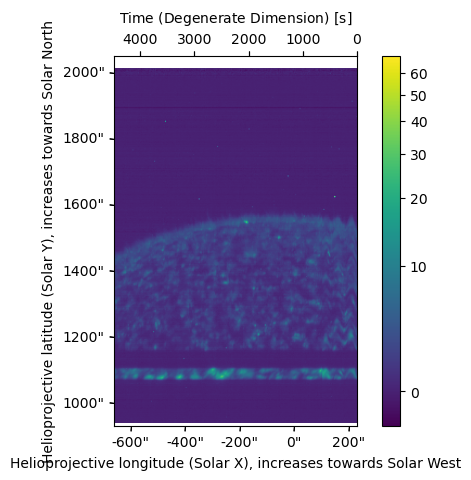

In [152]:
spice_cube_gwcs[0,10,:,:].plot(aspect=1/3,norm=ImageNormalize(stretch=AsinhStretch()))
plt.colorbar()

<WCSAxes: >

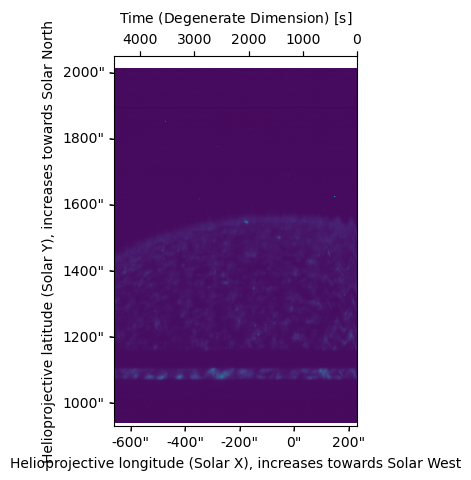

In [141]:
spice_cubes['C III 977 - Peak'][0,10,:,:].plot(aspect=1/3)

In [146]:
spice_cubes['C III 977 - Peak'][:,:,:,:].wcs

SlicedLowLevelWCS Transformation

This transformation has 4 pixel and 4 world dimensions

Array shape (Numpy order): (1, 36, 1024, 224)

Pixel Dim  Axis Name  Data size  Bounds
        0  None             224  None
        1  None            1024  None
        2  None              36  None
        3  None               1  None

World Dim  Axis Name                                                          Physical Type                   Units
        0  Helioprojective longitude (Solar X), increases towards Solar West  custom:pos.helioprojective.lon  deg
        1  Helioprojective latitude (Solar Y), increases towards Solar North  custom:pos.helioprojective.lat  deg
        2  Wavelength                                                         em.wl                           m
        3  Time (Degenerate Dimension)                                        time                            s

Correlation between pixel and world axes:

               Pixel Dim
World Dim    0    1    2    3
   

In [147]:
SlicedLowLevelWCS(spice_gwcs,slices=(slice(None),slice(None),slice(None),slice(None)))

SlicedLowLevelWCS Transformation

This transformation has 4 pixel and 4 world dimensions

Array shape (Numpy order): None

Pixel Dim  Axis Name  Data size  Bounds
        0  None            None  None
        1  None            None  None
        2  None            None  None
        3  None            None  None

World Dim  Axis Name                                                          Physical Type                   Units
        0  Helioprojective longitude (Solar X), increases towards Solar West  custom:pos.helioprojective.lon  deg
        1  Helioprojective latitude (Solar Y), increases towards Solar North  custom:pos.helioprojective.lat  deg
        2  Wavelength                                                         em.wl                           nm
        3  Time (Degenerate Dimension)                                        time                            s

Correlation between pixel and world axes:

               Pixel Dim
World Dim    0    1    2    3
        0  yes  

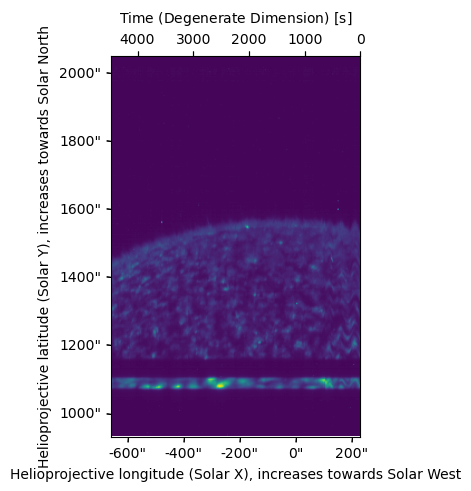

In [149]:
fig = plt.figure(layout='constrained')
ax = fig.add_subplot(projection=SlicedLowLevelWCS(spice_gwcs,slices=(0,0,slice(None),slice(None))))
ax.imshow(np.nansum(data,axis=(0,1)), origin='lower',aspect=1/3)

In [157]:
@custom_model
def ModelAdd(x,y):
    return x + y

In [165]:
spice_dist_step1 = models.Mapping((0,1,2,3,0,0))
spice_dist_step2 = shift_by_crpix & models.Tabular1D(np.arange(wcsdvarr_x.size), wcsdvarr_x) & \
        models.Tabular1D(np.arange(wcsdvarr_y.size), wcsdvarr_y)
spice_dist_step3 = models.Mapping((0,1,3,2,4,5))
spice_dist_step4 = AffineTransformation3D(matrix=rotation_matrix_drop_lambda) & models.Identity(3)
spice_dist_step5 = models.Mapping((0,1,3,2,4,5))
spice_dist_step6 = scale_by_cdelt & models.Scale(1/3600) & models.Scale(1/3600)
spice_dist_step7 = tangent_projection & models.Identity(2)
spice_dist_step8 = skyrot & models.Identity(2)
spice_dist_step9 = models.Mapping((0,4,1,5,2,3))
spice_dist_step10 = ModelAdd() & ModelAdd() & models.Identity(2)

det2sky_distortion = spice_dist_step1 | spice_dist_step2 | spice_dist_step3 | spice_dist_step4 | spice_dist_step5 | \
        spice_dist_step6 | spice_dist_step7 | spice_dist_step8 | spice_dist_step9 | spice_dist_step10

pipeline_distortion = [(detector_frame, det2sky_distortion), (sky_frame, None)]

spice_gwcs_distortion = gwcs.WCS(pipeline_distortion)

In [166]:
spice_gwcs_distortion.pixel_to_world(10,1,2,50)

[<SkyCoord (Helioprojective: obstime=2021-09-14T03:27:51.562, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2021-09-14T03:27:51.562, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
     (-47.27368371, 0.95868932, 8.78230809e+10)>): (Tx, Ty) in arcsec
     (-618.53269959, 939.30390553)>,
 <SpectralCoord 97.5781745 nm>,
 <Time object: scale='utc' format='isot' value=2021-09-14T04:02:31.410>]

In [169]:
spice_cube_gwcs_distortion = SpectrogramCube(data, wcs=spice_gwcs_distortion)

In [181]:
spice_cube_gwcs_distortion.reproject_to(spice_cube_gwcs.wcs, shape_out=spice_cube_gwcs.data.shape)

ValueError: too many values to unpack (expected 2)

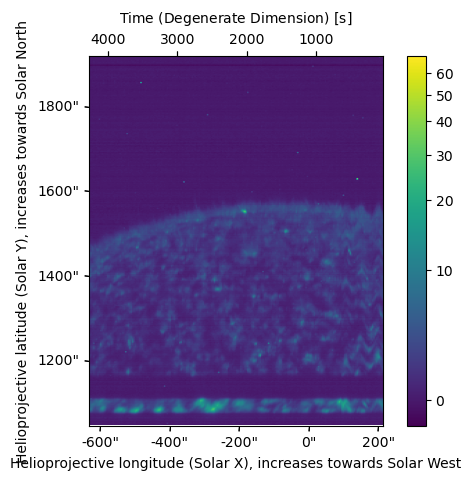

In [175]:
spice_cube_gwcs_distortion[0,10,100:900,10:222].plot(aspect=1/3,norm=ImageNormalize(stretch=AsinhStretch()))
plt.colorbar()

In [167]:
fig = plt.figure(layout='constrained')
ax = fig.add_subplot(projection=SlicedLowLevelWCS(spice_gwcs_distortion,slices=(0,0,slice(),slice(None))))
ax.imshow(np.nansum(data,axis=(0,1)), origin='lower',aspect=1/3)

Error in callback <function _draw_all_if_interactive at 0x7faf8c8384a0> (for post_execute), with arguments args (),kwargs {}:


ValueError: One of the requested xi is out of bounds in dimension 0

ValueError: One of the requested xi is out of bounds in dimension 0

<Figure size 640x480 with 1 Axes>